In [35]:
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list(
   name='test', 
   #colors=['red','white','green','white','red']
   colors=['#FF7575', '#00FF66'], N=100
)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
my_dict = {
'SPY':  'SPY Benchmark',
'QQQ':  'QQQ Nasdaq',
'XLY':  'XLY Consumer Discretionary',
'XLF':  'XLF Financial',
'XLK':  'XLK Technology',
'XLE':  'XLE Energy',
'XLV':  'XLV Health Care',
'XLI':  'XLI Industrial',  
'XLP':  'XLP Consumer Staples',   
'XLB':  'XLB Materials',
'XLU':  'XLU Utilities',
'XHB':  'XHB SPDR S&P Homebuilders',
'XLRE': 'XLRE Real Estate',
'XLC':  'XLC Communication Services',
'XAR':  'XAR SPDR S&P Aerospace & Defense',
'XITK': 'XITK FactSet Innovative Technology',
'XNTK': 'XNTK NYSE Technology',
'XAR': 'XAR Aerospace & Defense',
'KBE': 'KBE Bank',
'XBI': 'XBI Biotech',
'KCE': 'KCE Capital Markets',
'XHE': 'XHE Health Care Equipment',
'XHS': 'XHS Health Care Services',
'XHB': 'XHB Homebuilders',
'KIE': 'KIE Insurance',
'XWEB': 'XWEB Internet',
'XME': 'XME Metals & Mining',
'XES': 'XES Oil & Gas Equipment & Services',
'XOP': 'XOP Oil & Gas Exploration & Production',
'XPH': 'XPH Pharmaceuticals',
'KRE': 'KRE Regional Banking',
'XRT': 'XRT Retail',
'XSD': 'XSD Semiconductor',
'XSW': 'XSW Software & Services',
'XTH': 'XTH Technology Hardware',
'XTL': 'XTL Telecom',
'XTN': 'XTN Transportation',
}

In [3]:
def get_start_end_dates(days=10):
    end = datetime.today() 
    start = end - timedelta(days=days)
    return start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')

In [4]:
sd='1990-01-01'
ed='2019-12-31'
prices = [pdr.get_data_yahoo(ticker, start=sd, end=ed)['Adj Close'] for ticker in my_dict.keys()]
prices = pd.concat(prices,axis=1)
prices.columns = my_dict.keys()
prices.columns = prices.columns.map(my_dict)

In [8]:
prices.to_pickle('us_etf_prices.picke')

In [10]:
rets = np.log(prices/prices.shift(1))[1:]
sd, ed = get_start_end_dates(25)
print(sd,ed)
rets = rets.loc[sd:ed].cumsum().T
rets.columns = rets.columns.strftime('%d-%b')
rets = rets.sort_values(by=rets.columns[-1],ascending=False)
rets.style.format('{:,.2%}').background_gradient(cmap=cm,axis=1)

2019-10-31 2019-11-25


,31-Oct,01-Nov,04-Nov,05-Nov,06-Nov,07-Nov,08-Nov,11-Nov,12-Nov,13-Nov,14-Nov,15-Nov,18-Nov,19-Nov,20-Nov,21-Nov,22-Nov,25-Nov
XBI Biotech,-0.21%,2.25%,1.62%,1.62%,-0.10%,0.16%,2.61%,2.28%,2.62%,2.94%,2.26%,3.59%,3.87%,6.40%,6.72%,6.88%,7.46%,11.63%
XHS Health Care Services,-1.40%,1.26%,2.51%,2.99%,3.34%,3.83%,4.73%,3.83%,4.89%,5.07%,5.33%,7.86%,8.22%,8.98%,8.74%,9.14%,9.24%,11.12%
XHE Health Care Equipment,0.03%,1.33%,2.56%,1.96%,1.68%,2.68%,3.08%,2.76%,3.72%,3.56%,3.68%,5.32%,4.34%,5.45%,5.58%,5.46%,5.70%,7.62%
KCE Capital Markets,-0.32%,1.03%,2.47%,2.56%,2.40%,2.93%,2.82%,2.82%,3.05%,2.61%,2.75%,3.43%,3.50%,4.26%,4.31%,4.03%,4.74%,6.51%
XITK FactSet Innovative Technology,-0.87%,1.19%,1.51%,1.33%,0.74%,0.42%,1.66%,2.08%,2.57%,3.02%,2.78%,4.27%,4.56%,4.76%,4.96%,4.16%,4.64%,6.42%
XSD Semiconductor,0.81%,3.81%,5.60%,5.98%,4.66%,5.47%,6.44%,6.21%,6.99%,7.05%,6.52%,6.92%,6.08%,6.03%,4.24%,3.37%,3.46%,6.07%
XSW Software & Services,-0.78%,0.25%,0.23%,0.35%,0.06%,0.43%,0.73%,0.84%,1.45%,1.49%,1.79%,2.83%,3.01%,3.91%,3.92%,3.51%,3.67%,5.28%
XLK Technology,-0.06%,1.13%,1.65%,1.53%,1.48%,2.27%,2.83%,2.87%,3.21%,3.43%,3.31%,4.12%,4.42%,4.61%,4.00%,3.50%,3.37%,4.82%
XLV Health Care,-0.12%,0.01%,-0.30%,-1.01%,-0.67%,-0.44%,0.28%,-0.13%,0.47%,0.59%,0.60%,2.70%,2.36%,3.04%,2.91%,3.16%,3.52%,4.69%
XAR Aerospace & Defense,-0.26%,1.53%,0.56%,1.20%,1.63%,2.49%,3.78%,3.99%,4.37%,4.61%,5.30%,6.16%,5.93%,5.75%,5.93%,4.25%,4.10%,4.66%


In [12]:
rets = np.log(prices/prices.shift(1))[1:]
sd, ed = get_start_end_dates(25)
print(sd,ed)
rets = rets.loc[sd:ed].T
rets.columns = rets.columns.strftime('%d-%b')
rets = rets.sort_values(by=rets.columns[-1],ascending=False)
rets.style.format('{:,.2%}').background_gradient(cmap=cm,axis=1)

2019-10-31 2019-11-25


,31-Oct,01-Nov,04-Nov,05-Nov,06-Nov,07-Nov,08-Nov,11-Nov,12-Nov,13-Nov,14-Nov,15-Nov,18-Nov,19-Nov,20-Nov,21-Nov,22-Nov,25-Nov
XBI Biotech,-0.21%,2.46%,-0.62%,0.00%,-1.72%,0.26%,2.45%,-0.32%,0.33%,0.32%,-0.68%,1.33%,0.28%,2.53%,0.32%,0.16%,0.58%,4.17%
XES Oil & Gas Equipment & Services,-1.92%,4.81%,4.86%,-1.09%,-2.92%,0.84%,0.14%,-0.84%,-1.85%,-2.47%,-1.48%,2.65%,-2.95%,-1.66%,0.15%,2.40%,0.59%,3.48%
XSD Semiconductor,0.81%,3.00%,1.78%,0.39%,-1.32%,0.82%,0.96%,-0.22%,0.77%,0.06%,-0.53%,0.40%,-0.84%,-0.05%,-1.80%,-0.87%,0.09%,2.61%
XHE Health Care Equipment,0.03%,1.31%,1.23%,-0.61%,-0.27%,0.99%,0.41%,-0.32%,0.96%,-0.16%,0.12%,1.64%,-0.98%,1.11%,0.13%,-0.12%,0.24%,1.92%
XHS Health Care Services,-1.40%,2.65%,1.26%,0.47%,0.35%,0.49%,0.91%,-0.91%,1.07%,0.17%,0.26%,2.53%,0.37%,0.76%,-0.24%,0.40%,0.10%,1.88%
XITK FactSet Innovative Technology,-0.87%,2.06%,0.32%,-0.18%,-0.59%,-0.32%,1.24%,0.42%,0.50%,0.44%,-0.23%,1.49%,0.29%,0.21%,0.19%,-0.80%,0.48%,1.78%
KCE Capital Markets,-0.32%,1.36%,1.44%,0.09%,-0.16%,0.52%,-0.10%,0.00%,0.23%,-0.43%,0.14%,0.68%,0.07%,0.76%,0.05%,-0.27%,0.70%,1.78%
XRT Retail,-1.22%,1.22%,1.63%,1.23%,-0.42%,-0.13%,-0.52%,-0.07%,-0.18%,-0.52%,0.65%,0.99%,-0.09%,-1.96%,-1.28%,-0.32%,1.35%,1.65%
XTH Technology Hardware,-0.83%,2.24%,1.40%,0.79%,-0.87%,0.22%,0.13%,-0.49%,-0.36%,-0.67%,-0.19%,1.11%,-0.44%,0.09%,-0.41%,-0.52%,-0.20%,1.64%
XSW Software & Services,-0.78%,1.03%,-0.02%,0.12%,-0.29%,0.37%,0.30%,0.10%,0.61%,0.04%,0.30%,1.04%,0.18%,0.90%,0.01%,-0.41%,0.16%,1.61%


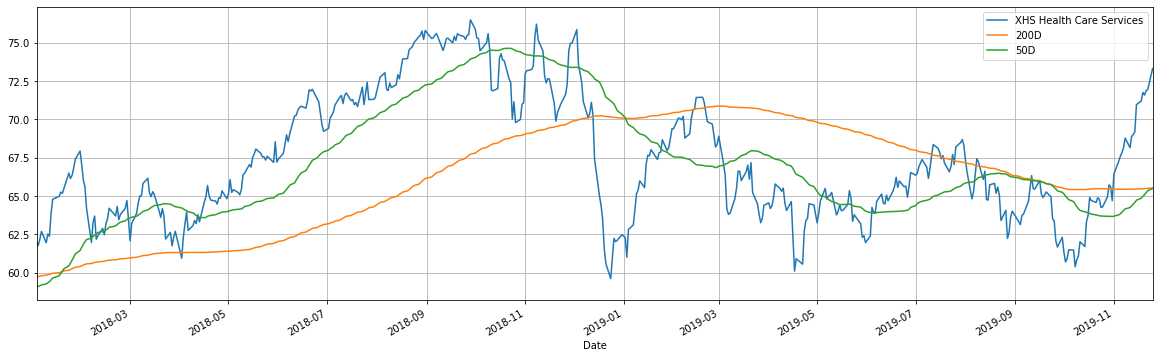

In [14]:
ticker = 'XHS'
temp = prices[prices.columns[prices.columns.str.contains(ticker)]].dropna().copy()
temp['200D'] = temp[temp.columns[0]].rolling(200).mean()
temp['50D'] = temp[temp.columns[0]].rolling(50).mean()
temp.loc['2018-01-01':'2019-12-31'].plot(grid=True,figsize=(20,6))

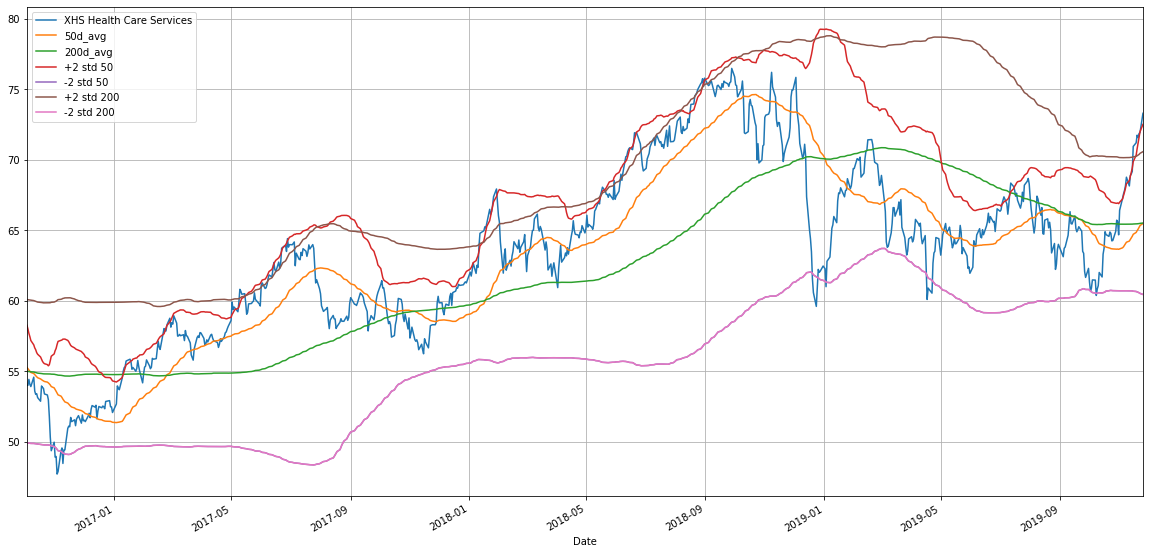

In [18]:
def bolinger_bands(price, window_size1, window_size2, num_of_std):

    rolling_mean1 = price.rolling(window=window_size1).mean()
    rolling_mean2 = price.rolling(window=window_size2).mean()
    
    rolling_std1  = price.rolling(window=window_size1).std()
    rolling_std2  = price.rolling(window=window_size2).std()
   
    upper_band1 = rolling_mean1 + (rolling_std1*num_of_std)
    lower_band1 = rolling_mean1 - (rolling_std1*num_of_std)

    upper_band2 = rolling_mean2 + (rolling_std2*num_of_std)
    lower_band2 = rolling_mean2 - (rolling_std2*num_of_std)

    df = pd.concat([price, rolling_mean1, rolling_mean2, upper_band1, lower_band2, upper_band2, lower_band2], axis=1)
    df.columns = [price.columns[0], 
                  f'{window_size1}d_avg',
                  f'{window_size2}d_avg', 
                  f'+{num_of_std} std {window_size1}', 
                  f'-{num_of_std} std {window_size1}',
                  f'+{num_of_std} std {window_size2}', 
                  f'-{num_of_std} std {window_size2}']
    return df

temp = bolinger_bands(prices.filter(regex=("XHS")),50, 200,2)
temp.loc['2016-10-01':'2019-12-31'].plot(grid=True, figsize=(20,10))

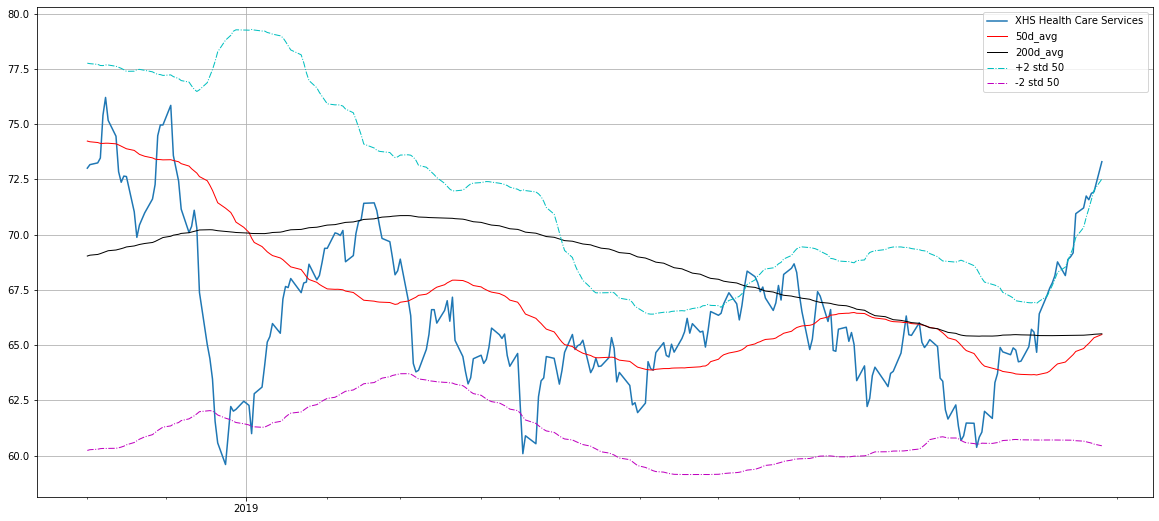

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
plt.grid=True
fig, ax = plt.subplots(figsize=(20, 10))
ax.grid(True)
# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

fig.autofmt_xdate()

temp = bolinger_bands(prices.filter(regex=("XHS")),50, 200,2).loc['2018-11-01':'2019-12-31']

plt.plot(temp['XHS Health Care Services'], label='XHS Health Care Services')

plt.plot(temp['50d_avg'], color='r', linestyle='solid', linewidth=1, label='50d_avg')
plt.plot(temp['200d_avg'], color='k', linestyle='solid', linewidth=1, label='200d_avg')

plt.plot(temp['+2 std 50'], color='c', linestyle='dashdot', linewidth=1, label='+2 std 50')
plt.plot(temp['-2 std 50'], color='m', linestyle='dashdot', linewidth=1, label='-2 std 50')


plt.legend()
plt.show()

In [26]:
def get_etf_holdings_returns(ticker):
    holdings = pd.read_html(f'https://uk.finance.yahoo.com/quote/{ticker}/holdings')[0]
    sd='1990-01-01'
    ed='2019-12-31'
    prices = [pdr.get_data_yahoo(ticker, start=sd, end=ed)['Adj Close'] for ticker in holdings['Symbol']]
    prices = pd.concat(prices,axis=1)
    prices.columns = holdings['Symbol']
    return holdings, prices

In [33]:
holdings, prices = get_etf_holdings_returns('XHS')

In [36]:
rets = np.log(prices/prices.shift(1))[1:]
rets.index.name = None
rets.columns.name = None
sd, ed = get_start_end_dates(25)
print(sd,ed)
rets = rets.loc[sd:ed].cumsum().T
rets.columns = rets.columns.strftime('%d-%b')
rets = rets.sort_values(by=rets.columns[-1],ascending=False)
rets.style.format('{:,.2%}').background_gradient(cmap=cm,axis=1)

2019-10-31 2019-11-25


,31-Oct,01-Nov,04-Nov,05-Nov,06-Nov,07-Nov,08-Nov,11-Nov,12-Nov,13-Nov,14-Nov,15-Nov,18-Nov,19-Nov,20-Nov,21-Nov,22-Nov,25-Nov
HUM,0.00%,0.68%,0.95%,0.19%,3.59%,6.88%,7.65%,7.64%,8.50%,8.07%,7.78%,13.15%,12.85%,13.33%,13.81%,14.02%,13.95%,15.88%
CI,1.14%,1.72%,3.72%,3.02%,3.72%,4.92%,6.45%,5.90%,6.86%,7.54%,7.25%,10.52%,11.72%,12.54%,12.49%,13.14%,13.45%,14.45%
CVS,-0.99%,0.28%,1.47%,0.40%,5.63%,6.82%,7.77%,6.75%,7.61%,8.26%,8.42%,10.25%,11.34%,11.67%,11.10%,11.12%,11.62%,13.29%
CNC,-1.79%,-3.60%,-4.41%,-4.16%,-6.12%,-1.77%,1.87%,-0.15%,2.12%,2.40%,1.12%,6.31%,9.39%,9.44%,9.56%,9.94%,9.54%,12.39%
CAH,-1.43%,0.56%,3.10%,2.64%,2.50%,5.88%,6.91%,6.78%,7.43%,8.83%,8.76%,11.44%,11.03%,10.44%,9.95%,9.52%,10.46%,11.64%
UNH,-0.83%,-1.02%,-1.40%,-1.78%,-1.69%,0.65%,0.85%,-0.28%,0.18%,-0.48%,0.40%,5.57%,6.87%,7.35%,7.83%,8.19%,8.30%,10.38%
WCG,-0.93%,-2.04%,-2.65%,-2.43%,-3.36%,-0.85%,1.19%,-0.01%,1.50%,1.69%,0.81%,4.18%,6.05%,6.10%,6.19%,6.47%,6.15%,7.92%
ANTM,-1.61%,-1.00%,-0.64%,-0.17%,1.40%,2.28%,3.11%,2.06%,3.67%,3.69%,3.08%,8.53%,7.24%,6.81%,6.80%,7.15%,6.50%,7.21%
HCA,-0.92%,-0.83%,1.07%,-0.32%,0.07%,1.06%,1.52%,0.41%,0.27%,-0.28%,-0.21%,2.40%,1.48%,2.95%,3.64%,3.30%,3.23%,4.90%
AMN,-0.37%,-0.49%,1.66%,2.05%,2.64%,2.41%,2.59%,1.55%,2.45%,1.33%,0.83%,1.16%,1.66%,2.59%,0.59%,0.81%,1.10%,2.46%


In [37]:
holdings

,Name,Symbol,% assets
0,Centene Corp,CNC,2.95%
1,Cigna Corp,CI,2.80%
2,WellCare Health Plans Inc,WCG,2.80%
3,UnitedHealth Group Inc,UNH,2.73%
4,Humana Inc,HUM,2.69%
5,Anthem Inc,ANTM,2.68%
6,AMN Healthcare Services Inc,AMN,2.66%
7,CVS Health Corp,CVS,2.61%
8,HCA Healthcare Inc,HCA,2.61%
9,Cardinal Health Inc,CAH,2.59%
